# 94889 Preliminary Exercise

## Overview

The purpose of this exercise is to provide a assessment on a few of the technical skills you'll need in Machine Learning for Public Policy Lab (94-889) and help us make sure everyone coming in has the necessary pre-requisites including python, data analysis, databases/sql, and machine learning.

Feel free to use any references (previous class notes, google, stackoverflow, etc) you would like, but please complete the exercise on your own to ensure the work reflects your experience. **Completing this notebook should take you under 3 hours** -- if you're finding you need to take significantly more time on, you may find it difficult to contribute to the project work in the class.

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers). Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, we'll imagine that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has time to review and support only 10% of the projects posted to the platform on a given day.

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to identify projects that are least likely to be fully funded before they expire and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [1]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main
 * Starting PostgreSQL 11 database server
   ...done.
ALTER ROLE
DROP DATABASE
CREATE DATABASE
env: DEMO_DATABASE_NAME=donors_choose
env: DEMO_DATABASE_HOST=localhost
env: DEMO_DATABASE_PORT=5432
env: DEMO_DATABASE_USER=postgres
env: DEMO_DATABASE_PASS=postgres


In [2]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [3]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [5]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [6]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

# QUESTION 1

**(A)** Write a query to return the school id, title, date posted, and total asking price for the latest posted project from each school in New York.

In [8]:
query = """SELECT DISTINCT p.schoolid, e.title, p.date_posted, p.total_asking_price
           FROM data.projects p JOIN data.essays e USING(projectid_str)
           WHERE (p.schoolid, p.date_posted) IN (SELECT schoolid, MAX(date_posted)
                                                 FROM data.projects
                                                 WHERE school_state = 'NY'
                                                 GROUP BY schoolid)
           ORDER BY p.schoolid
        """

latest_ny = pd.read_sql(query, db_engine)
latest_ny

,schoolid,title,date_posted,total_asking_price
0,04816827b614a629b4012f15662f1ccc,Automotive Dashboard Design,2013-11-15,2085.00
1,0690cb801caeb9ccfb5bb0a16ff39afd,Helping Students Share High-Tech Projects,2011-05-01,452.99
2,0743663d3cee056d5e27714cde6b2a81,Three Dimensional Materials Needed,2014-04-17,704.60
3,09a626e28da1314a2df6134a4850b1ae,Writing Sticks,2014-05-11,156.78
4,116465cd87c2c6c7a2fc7f3670853d7f,"A ""Room"" of Our Own: Bring a Real World Exper...",2012-03-03,973.37
...,...,...,...,...
104,f69d0e22b224553c112c20f4cdebfd58,Kindergarten Needs Basic Supplies And Software...,2013-08-23,814.52
105,f7bded84c7480a5dc45706c5f8b500c7,Diversity Coloring Time,2011-02-02,337.86
106,f89a87c99d5a412b50429e67872a22ba,Getting Ready for the Pro Start Competition!,2014-03-07,328.69
107,fda332588aac0461464a25b6cf755a72,Five People You Meet in Heaven,2014-05-01,427.58


**(B)** Write a query to return the top 10 cities in terms of projects that got fully funded (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

In [9]:
query = """WITH Funded_Projects AS (SELECT p.projectid_str, p.schoolid, p.total_asking_price, p.school_city, COALESCE(SUM(d.donation_total), 0) AS total_donated
                                  FROM data.projects p LEFT JOIN data.donations d ON p.projectid_str = d.projectid_str
                                  GROUP BY p.projectid_str, p.schoolid, p.total_asking_price, p.school_city
                                  HAVING COALESCE(SUM(d.donation_total), 0) > total_asking_price)
           SELECT school_city, COUNT(projectid_str) AS number_of_fully_funded_projects
           FROM Funded_Projects
           GROUP BY school_city
           ORDER BY number_of_fully_funded_projects DESC
           LIMIT 10
        """

top_funded_cities = pd.read_sql(query, db_engine)
top_funded_cities

,school_city,number_of_fully_funded_projects
0,Bronx,828
1,Chicago,539
2,Oakland,292
3,Los Angeles,257
4,Brooklyn,246
5,Indianapolis,242
6,Houston,239
7,Durham,217
8,Philadelphia,207
9,Henderson,184


**(C)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

In [10]:
query = """SELECT projectid_str, COUNT(r.resourceid) AS rsrc_cnt, SUM(r.item_quantity) AS no_of_items, SUM(d.donation_total)/p.total_asking_price AS fraction_funded
           FROM data.projects p JOIN data.donations d USING (projectid_str)
                  JOIN (SELECT DISTINCT * FROM data.resources) r USING (projectid_str)
           WHERE school_state = 'NH'
           GROUP BY projectid_str, p.total_asking_price
           ORDER BY projectid_str
        """

total_funding_nh = pd.read_sql(query, db_engine)
total_funding_nh

,projectid_str,rsrc_cnt,no_of_items,fraction_funded
0,0423c18927379ee4091d11aabfb12ef3,8,8.0,1.149445
1,181b32a7a1ce28950c8ef9941a9f6245,18,18.0,7.058893
2,1a3aaeffc56dd2a421e37d8298024c0a,6,8.0,0.631380
3,2802507fd30a5839f672174e8685d10f,5,110.0,0.256777
4,2845815efe9e21b49c088ac0556b57c6,1,10.0,0.162525
5,472bc074672ffc4021c8b4d8ba5d5a5f,12,24.0,1.219512
6,4ea2875bd43ebc8a2cd74bfdaa3aa11d,2,2.0,0.112187
7,5870c45161349bdbc0def1a5631d43ce,26,36.0,15.293907
8,5c16a1a98221b16621d873c9261e593d,16,184.0,4.733963
9,627d3158c2e899318c7e9b6722eaff8f,6,6.0,2.500000


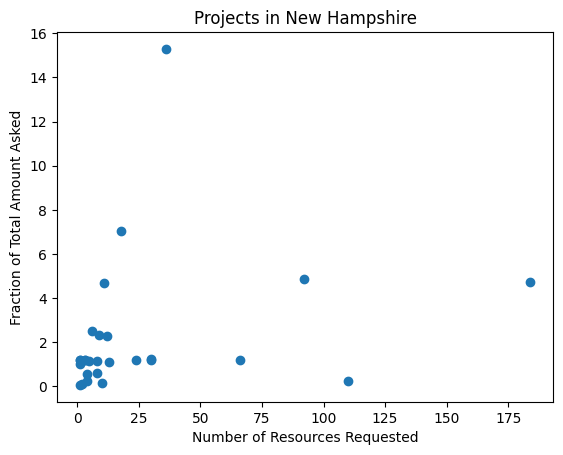

In [11]:
#Scatterplot
x = total_funding_nh[["no_of_items"]]
y = total_funding_nh[["fraction_funded"]]
plt.scatter(x, y)
plt.title("Projects in New Hampshire")
plt.xlabel("Number of Resources Requested")
plt.ylabel("Fraction of Total Amount Asked")
plt.show()

# Question 2

For this question, you'll develop a model to help DonorsChoose identify 10% of projects to have their digital content expert review that are at highest risk of failing to reach their funding goal. In order to intervene early in the process, DonorsChoose wants to identify these projects to help immediately upon being posted to the site.

Build and evaluate the performance of a handful of machine learning models for this task. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Note that you don't need to explore an extensive model space here -- building 3 or 4 models should be fine for the purposes of this exercise. Feel free to use any python packages available (such as sklearn) for this.

Make sure to read the context provided in Problem Background section above to make design choices that match the goal and needs of the organization and explain how and why you set up the problem in the way that you decide to do.

In [12]:
## Exploratory Data Analysis

In [13]:
projects = pd.read_sql("SELECT * FROM data.projects", db_engine)
essays = pd.read_sql("SELECT * FROM data.essays", db_engine)
resources = pd.read_sql("SELECT * FROM data.resources", db_engine)
donations = pd.read_sql("SELECT * FROM data.donations", db_engine)

In [14]:
projects.head()

,schoolid,projectid_str,teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,entity_id
0,29a2da790e38b6c8a1c70aced6b9c765,30c034618e67d00c641f9b5b7775c0f4,0903da60e148adc6280d55f5d94791a5,192013001182,41.428391,-91.049135,Muscatine,IA,52761,None,Muscatine Cmty School District,Muscatine,False,False,False,False,False,False,Ms.,False,False,Applied Sciences,Math & Science,College & Career Prep,Applied Learning,Supplies,high poverty,Grades 6-8,35.0,511.32,601.55,100,False,False,2012-08-06,234148
1,06ef48acbdf9b013d4bc4bfc8d328cc1,94199c544d9d2926c1820e5c6cde1eb6,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,ESL,Literacy & Language,Supplies,high poverty,Grades 3-5,35.0,167.43,192.45,40,False,False,2010-07-10,453579
2,06ef48acbdf9b013d4bc4bfc8d328cc1,61f42f174afef1ed2419ab948a647137,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,Applied Sciences,Math & Science,Other,high poverty,Grades 3-5,35.0,167.43,196.98,45,False,False,2011-06-09,353855
3,06ef48acbdf9b013d4bc4bfc8d328cc1,c966f5226f42aaaf6b115d7dbaefdea3,e0b5a72f41a376b28db9c2e838a24de5,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,Health & Life Science,Math & Science,Other,high poverty,Grades 3-5,35.0,162.14,190.75,25,False,False,2011-06-13,353178
4,06ef48acbdf9b013d4bc4bfc8d328cc1,69e9c24111daa1e6ba64c6d5538e4df1,32e86c49396707f71fdc0398ab2b844b,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Mrs.,False,False,History & Geography,History & Civics,Environmental Science,Math & Science,Books,high poverty,Grades 3-5,35.0,381.27,448.55,25,False,False,2012-07-15,239363


In [15]:
essays.head()

,projectid_str,teacher_acctid,title,short_description,need_statement,essay,entity_id,date_posted
0,cf14f53fd579fc390dc96771d5208e24,ab44698e75d5a9047c38a72ec35b2d02,Widen the Horizons of Small Town Kids,"This trip is one way, as the History Channel p...",The cost of a trip to Boston for 36 students i...,I teach advanced placement students in U.S....,628380,2006-12-10
1,967a122629b1d3fc2b9a7c4a04b55c85,2a1d704e1e8e372c4b096845b18d10ab,Can You Hear Us?,This project no longer needs funding.,This project no longer needs funding.,This project no longer needs funding.,345972,2011-07-26
2,45f26734dc3b18ad9513b36589d10383,cc1360fd8093c47d1c49fbb33bc193c8,Flute-tastic!,Replacing our non-functioning instruments with...,My students need a durable flute for use in ba...,Music program in a large urban high school:\r\...,499223,2009-10-06
3,156274e06d4b805d39149bc4d7655d99,a57e170e33e47ef528756c2a1e986e74,Challenge Me Today to Achieve Greatness Tomorrow,Sara requires a little extra help with her add...,My students need an iPod Touch.,Sara requires a little extra help with her add...,337103,2011-08-23
4,fec2af5bc6d7f1bbbe0a209f868efc65,ac7152d00f35598954a265c4a27a57da,Educational Tools for Math/Writing/Science/Rea...,If I had the Qclick Audio Response System in m...,My students need the qclick response system to...,There are many challenges facing the students ...,470255,2010-03-16


In [16]:
resources.head()

,resourceid,projectid_str,vendorid,vendor_name,project_resource_type,item_name,item_number,item_unit_price,item_quantity,entity_id,date_posted
0,202d2fe1164630c3e18623345650175d,0000fa3aa8f6649abab23615b546016d,7,AKJ Books,Books,Soft Rain,9780440412427,4.43,30.0,255654,2012-04-07
1,f0fa19ae0953d19e8ec670309fc8da72,071c87944d727b6dff382271125ff669,None,None,Trips,None,None,NaN,NaN,218307,2012-09-14
2,7ac0367031ced1660b7ce7bc903a29b1,07b961fee8623e35526bc6168d2911e9,7,AKJ Books,Books,The Purple Balloon,9780375841460,13.25,1.0,376890,2011-03-06
3,40d597c5b2889f95e37ad3d795dece16,0859ba7d65068d8028b7b8a06c6a3f8c,None,None,Trips,None,None,NaN,NaN,604216,2007-11-08
4,51e72dfc8c2b4c1a51045b2c3ccd5579,0aca0bb0e24f7b3731ce6af5321628d7,7,AKJ Books,Supplies,Graffiti Women,9780810957473,25.55,1.0,88543,2013-10-03


In [17]:
donations.head()

,donationid,projectid_str,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_creadit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message,entity_id
0,705ef855c2d90eed594cf26e634add93,fb9d9bebbd2309cbd948a03c00ec65b0,112631d2731d90f8ac0ae542d67904fe,,None,None,False,2009-11-09 10:49:34.648,41.00,9.00,50.0,10_to_100,True,no_cash_received,False,True,False,False,False,False,None,495172
1,59b71f584f3516f75d4e98d8acbaa65f,f93456e60338550f3ad7a2a0e87617dd,127936d3a07b33d3012bb23a9464532a,Austin,TX,78704,False,2011-09-02 08:48:01.447,85.00,15.00,100.0,100_and_up,True,paypal,False,False,False,False,True,False,None,336273
2,8bcc055f586e0343dd8779fdd8ac4775,f7848f096af41049e8dc6af81139d2b6,55223d1a24127d2fcce3a0b45e917b03,Chicago,IL,60093,False,2013-12-01 09:49:55.145,17.00,3.00,20.0,10_to_100,True,amazon,False,False,False,False,False,False,None,99049
3,3afbbc4257049362dab620251c49a4a0,f3d5ec1500fe57584856d4cce2d66161,88c6f8743b0340853b548404f8de9e5b,None,PR,None,False,2013-05-13 09:41:48.006,4.25,0.75,5.0,under_10,True,no_cash_received,False,True,False,False,False,False,Cause,173719
4,acf6e26e501def0b285834026459e592,f33b72a6093a64696d3a8e7ef2d0afa7,85e51d426e69e46b785b0225117b7e8b,None,None,None,True,2011-01-11 18:58:57.280,8.50,1.50,10.0,10_to_100,True,creditcard,False,False,False,False,True,False,None,395246


In [18]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(projects)
# missing_data(essays)
# missing_data(resources)
# missing_data(donations)


,Total,Percent
secondary_focus_subject,5401,32.773058
secondary_focus_area,5401,32.773058
school_metro,1948,11.820388
fulfillment_labor_materials,813,4.933252
school_ncesid,26,0.157767
primary_focus_subject,0,0.000000
primary_focus_area,0,0.000000
resource_type,0,0.000000
poverty_level,0,0.000000
grade_level,0,0.000000


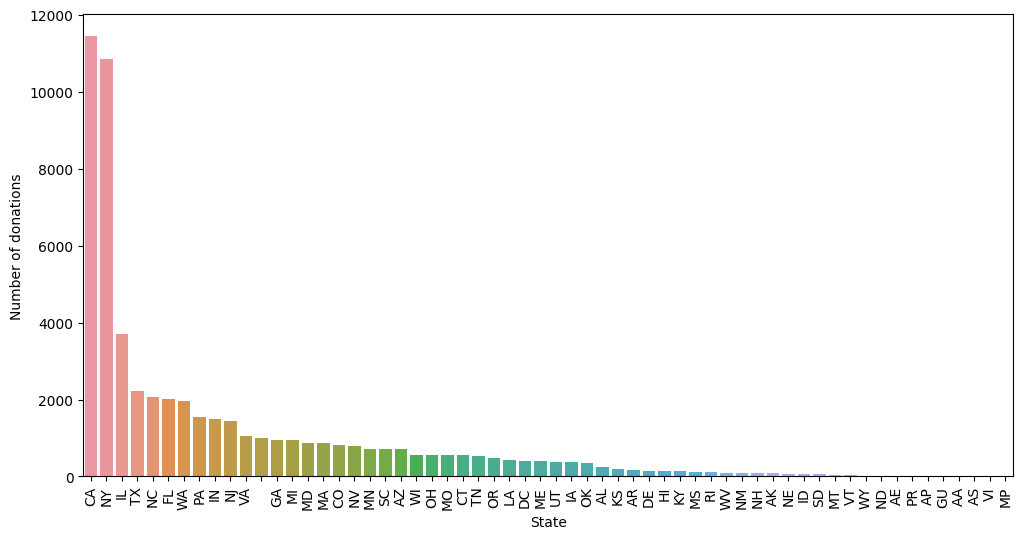

In [19]:
## Total Number of Donations Per State
tmp = donations['donor_state'].value_counts()
df1 = pd.DataFrame({'State': tmp.index,'Number of donations': tmp.values})
fig, (ax1) = plt.subplots(ncols=1, figsize=(12,6))
s = sns.barplot(ax = ax1, x = 'State', y="Number of donations", data=df1)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show();

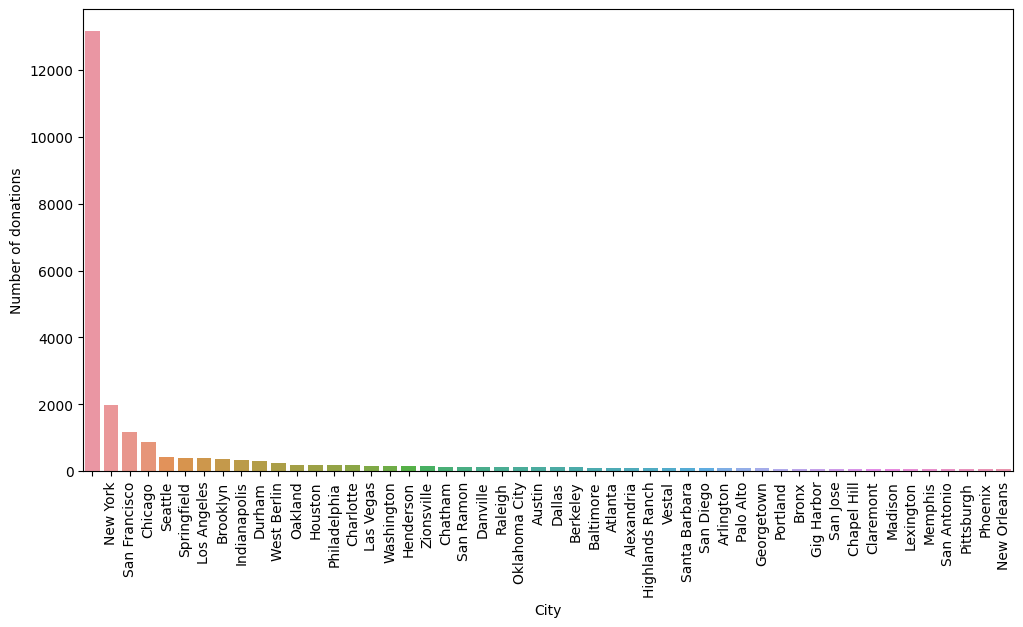

In [20]:
## Top donation city
tmp = donations['donor_city'].value_counts().head(50)
df1 = pd.DataFrame({'City': tmp.index,'Number of donations': tmp.values})
fig, (ax1) = plt.subplots(ncols=1, figsize=(12,6))
s = sns.barplot(ax = ax1, x = 'City', y="Number of donations",data=df1)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show();

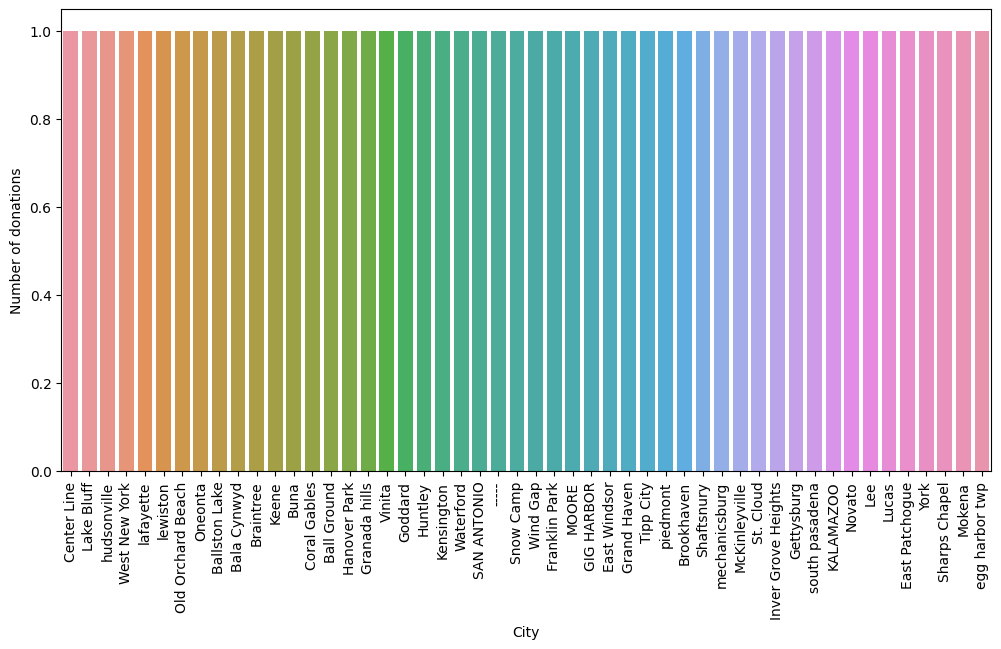

In [21]:
# Bottom donor cities
tmp = donations['donor_city'].value_counts().tail(50)
df1 = pd.DataFrame({'City': tmp.index,'Number of donations': tmp.values})
fig, (ax1) = plt.subplots(ncols=1, figsize=(12,6))
s = sns.barplot(ax = ax1, x = 'City', y="Number of donations",data=df1)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show();

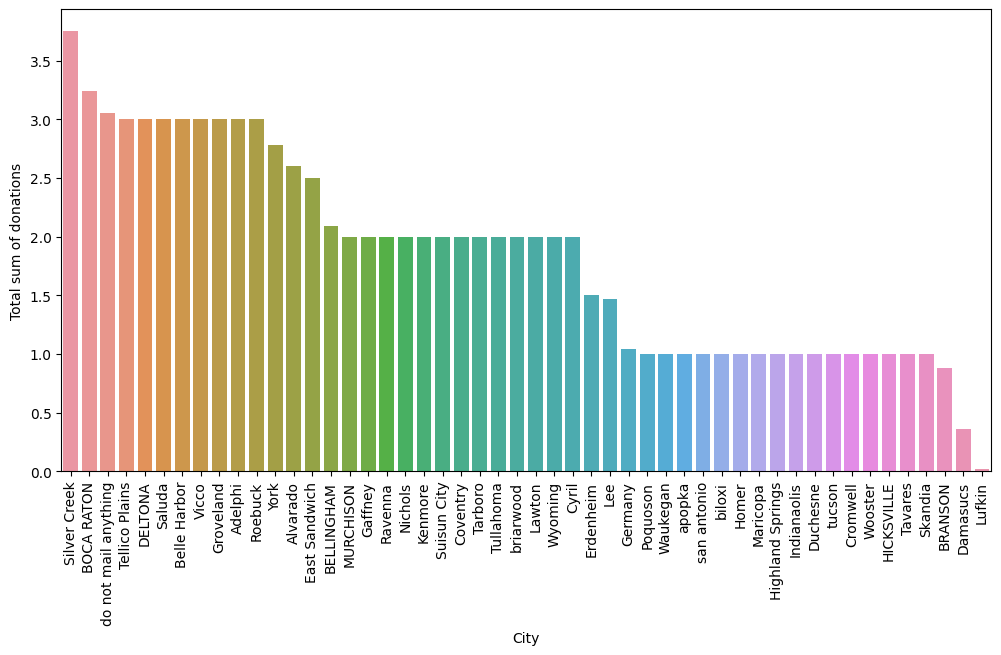

In [22]:
# Bottom donor cities (funding)
tmp = donations.groupby('donor_city')['donation_total'].sum()
df1 = pd.DataFrame({'City': tmp.index,'Total sum of donations': tmp.values})
df1.sort_values(by='Total sum of donations',ascending=False, inplace=True)
fig, (ax1) = plt.subplots(ncols=1, figsize=(12,6))
s = sns.barplot(ax = ax1, x = 'City', y="Total sum of donations",data=df1.tail(50))
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show();

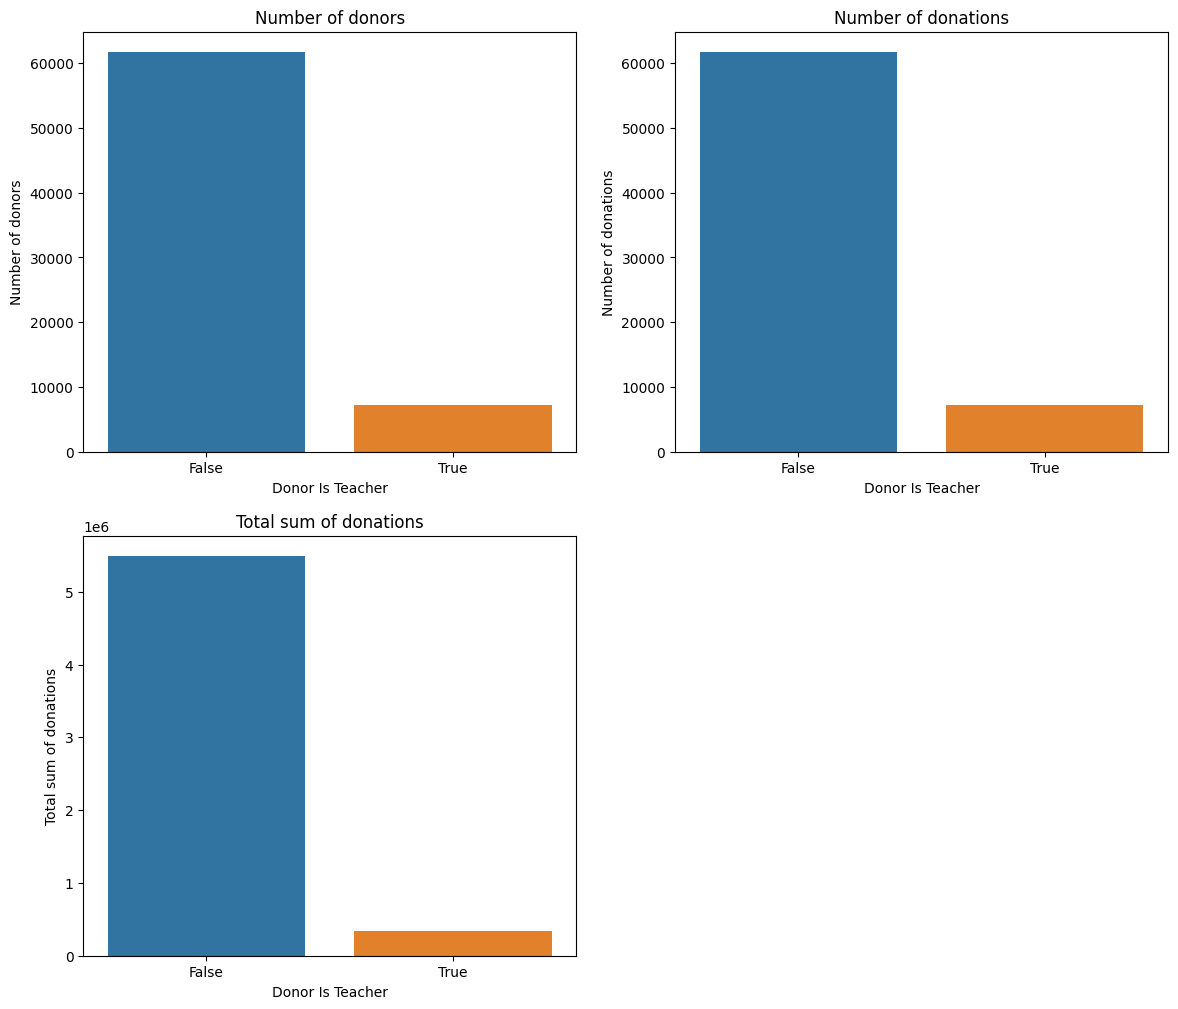

In [23]:
# interested to know how many donations are coming from teachers
tmp = donations['is_teacher_acct'].value_counts()
df1 = pd.DataFrame({'Donor Is Teacher': tmp.index,'Number of donors': tmp.values})

tmp = donations['is_teacher_acct'].value_counts()
df2 = pd.DataFrame({'Donor Is Teacher': tmp.index,'Number of donations': tmp.values})

tmp = donations.groupby('is_teacher_acct')['donation_total'].sum()
df3 = pd.DataFrame({'Donor Is Teacher': tmp.index,'Total sum of donations': tmp.values})


plt.figure(figsize = (14,12))

plt.subplot(2,2,1)
s = sns.barplot(x = 'Donor Is Teacher', y="Number of donors",data=df1)
plt.title("Number of donors")

plt.subplot(2,2,2)
s = sns.barplot(x = 'Donor Is Teacher', y="Number of donations",data=df2)
plt.title("Number of donations")

plt.subplot(2,2,3)
s = sns.barplot(x = 'Donor Is Teacher', y="Total sum of donations",data=df3.tail(50))
plt.title("Total sum of donations")

plt.show();

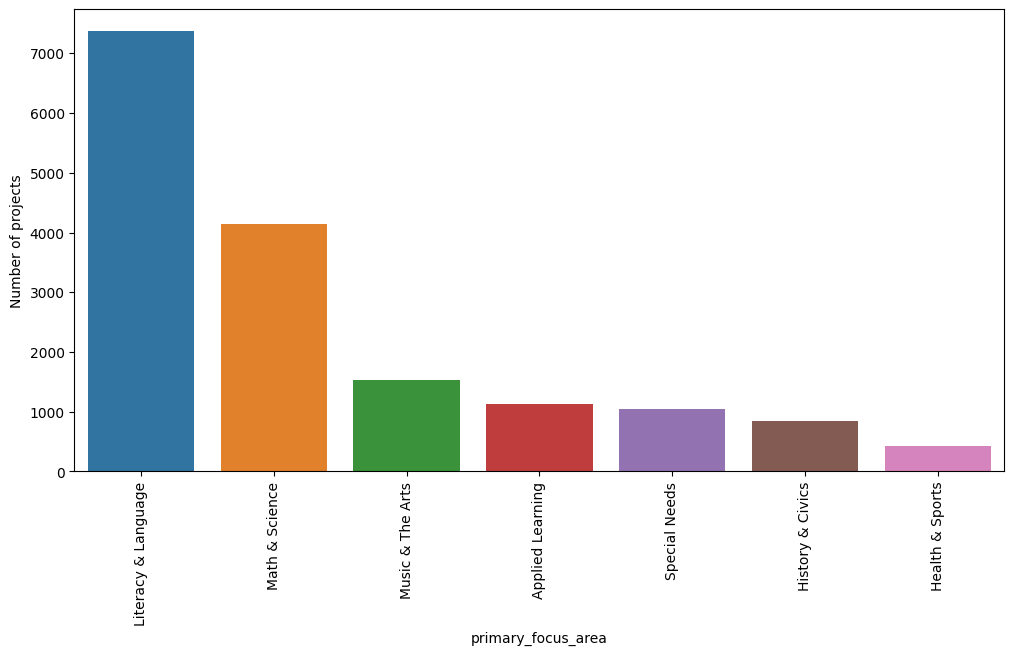

In [24]:
# Project subject category tree
def plot_category(feature):
    tmp = projects[feature].value_counts().sort_values(ascending = False).head(20)
    df1 = pd.DataFrame({feature: tmp.index,'Number of projects': tmp.values})
    fig, (ax1) = plt.subplots(ncols=1, figsize=(12,6))
    s = sns.barplot(ax = ax1, x = feature, y="Number of projects",data=df1)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

plot_category('primary_focus_area')

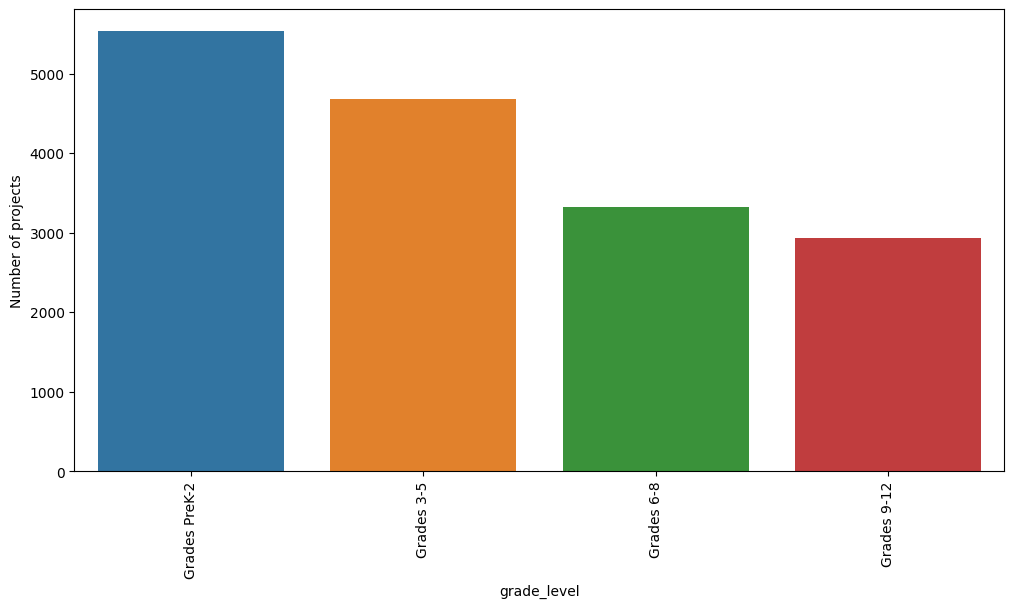

In [25]:
plot_category('grade_level')

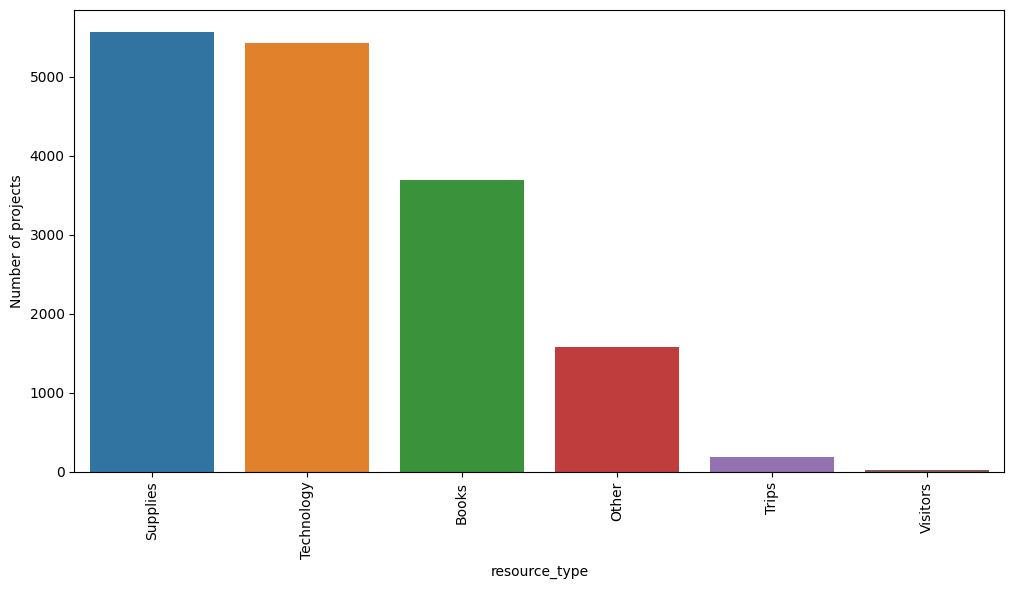

In [26]:
plot_category('resource_type')

In [27]:
# Building the models

In [28]:
## Ended up being too many columns and would require PCA for dimensionality reduction

# outcomes = pd.read_sql("SELECT * FROM data.outcomes", db_engine)
# df1 = projects.merge(essays, on="projectid_str", how='outer')
# df2 = df1.merge(resources, on="projectid_str", how='outer')
# df3 = df2.merge(donations, on="projectid_str", how='outer')
# df = df3.merge(outcomes, on="projectid_str", how='outer')

# df

df = pd.read_sql("SELECT * FROM data.projects p JOIN data.outcomes o USING (projectid_str)", db_engine)

In [29]:
# Check missing values
df.isnull().sum()

# Drop rows with NaN and specified columns
data2 = df.dropna().drop(columns=["teacher_prefix", "date_posted"])

# Factorize categorical columns
cat_columns = data2.select_dtypes(['object']).columns
for col in cat_columns:
    data2[col], _ = pd.factorize(data2[col])

# Replace boolean values
data2.replace({False: 0, True: 1}, inplace=True)

data2

,projectid_str,schoolid,teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,entity_id,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_reffered_count,non_teacher_referred_count,entity_id
1,0,0,0,0,32.233070,-80.855905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.0,167.43,192.45,40,0,0,453579,0,0,1,0,1,0,0,0,100.0,0.0,1.0,453579
2,1,0,0,0,32.233070,-80.855905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,35.0,167.43,196.98,45,0,0,353855,0,0,1,0,1,0,0,0,100.0,0.0,1.0,353855
3,2,0,1,0,32.233070,-80.855905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,35.0,162.14,190.75,25,0,0,353178,0,0,1,0,1,0,0,0,100.0,0.0,1.0,353178
4,3,0,2,0,32.233070,-80.855905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1,2,0,0,35.0,381.27,448.55,25,0,0,239363,0,0,0,0,1,0,1,0,100.0,0.0,2.0,239363
8,4,1,3,1,36.058694,-79.295504,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,2,1,3,0,0,9.0,645.61,787.33,22,0,1,480858,0,0,1,0,0,0,0,0,50.0,0.0,2.0,480858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15194,6451,875,3175,830,34.477279,-81.633629,589,0,822,0,602,351,0,0,0,0,0,0,0,0,6,2,3,1,0,1,0,35.0,391.32,449.79,22,1,0,454468,0,0,1,0,0,0,0,0,0.0,0.0,2.0,454468
15195,6452,875,3174,830,34.477279,-81.633629,589,0,822,0,602,351,0,0,0,0,0,0,0,0,2,2,20,4,2,1,2,35.0,427.93,503.45,7,1,0,443281,0,0,1,0,1,1,0,0,71.0,0.0,8.0,443281
15197,6453,875,3175,830,34.477279,-81.633629,589,0,822,0,602,351,0,0,0,0,0,0,0,0,7,2,17,6,0,1,0,35.0,427.38,502.80,60,1,0,378963,0,0,1,0,0,1,0,0,33.0,0.0,5.0,378963
15202,6454,875,3176,830,34.477279,-81.633629,589,0,822,0,602,351,0,0,0,0,0,0,0,0,0,0,4,0,2,1,1,35.0,416.92,490.49,19,0,0,308040,0,0,0,1,1,0,1,0,100.0,0.0,1.0,308040


In [30]:
# Splitting the dataset into training and testing
target = data2["fully_funded"]
features = data2.loc[:, data2.columns != "fully_funded"]
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.25,
                                                    random_state=16)
X_train

,projectid_str,schoolid,teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,entity_id,is_exciting,at_least_1_teacher_referred_donor,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_reffered_count,non_teacher_referred_count,entity_id
4065,1746,237,857,223,40.836826,-73.887688,21,8,234,2,9,21,0,0,0,1,0,0,0,0,5,0,16,2,0,1,3,35.0,933.94,1098.75,25,0,0,409339,0,0,1,0,0,0,0,0.0,0.0,1.0,409339
4923,2111,269,980,16,41.895340,-87.717896,11,9,265,2,97,11,1,0,0,0,0,0,1,0,0,0,4,0,2,1,2,30.0,504.79,593.87,90,0,0,143986,0,0,0,1,0,0,0,100.0,0.0,2.0,143986
12326,5170,707,2579,673,33.177458,-117.357945,495,7,673,1,508,107,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,35.0,472.47,555.85,25,0,0,268397,0,1,0,1,0,1,0,100.0,1.0,1.0,268397
10916,4614,620,2300,591,26.709193,-80.210123,445,15,593,1,108,91,0,0,0,0,0,0,0,0,1,1,8,2,2,0,2,30.0,404.18,475.51,35,1,0,118228,0,0,0,1,1,0,0,66.0,0.0,3.0,118228
2945,1245,178,634,168,37.788569,-122.204951,146,7,176,2,151,117,0,0,0,0,0,0,0,0,4,2,3,1,0,1,0,35.0,200.70,236.12,430,0,0,338839,1,1,0,1,0,0,0,100.0,1.0,1.0,338839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10797,4548,612,2267,583,36.191929,-115.081337,12,10,585,1,12,12,0,0,0,0,0,0,0,0,0,0,15,3,3,1,0,35.0,440.65,518.41,30,1,1,333621,1,1,0,1,1,0,0,75.0,1.0,5.0,333621
1688,635,108,354,103,35.341433,-118.932203,95,7,107,2,94,81,0,0,0,0,0,0,0,0,2,2,0,0,3,1,3,35.0,548.21,644.95,140,1,0,304060,0,0,1,0,0,0,0,0.0,0.0,2.0,304060
3145,1345,185,689,175,32.665333,-93.747322,152,25,183,0,138,105,0,0,0,0,0,0,0,0,2,2,22,4,3,2,3,30.0,332.56,391.25,185,0,0,77960,0,0,1,0,0,0,0,0.0,0.0,1.0,77960
1567,581,99,324,94,40.591152,-73.938599,25,8,98,2,87,9,0,0,1,0,0,0,0,0,5,0,7,1,0,0,2,35.0,335.90,395.18,12,1,0,303076,0,1,0,0,1,0,0,45.0,3.0,7.0,303076


In [31]:
# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
y_pred = knn.predict(X_test)
print(y_pred)
scores = metrics.accuracy_score(y_test,y_pred)
print(scores)

[0 1 1 ... 1 1 1]
0.8159851301115242


In [33]:
cm_donors = confusion_matrix(y_test,y_pred)
print(cm_donors)

[[  16  242]
 [  55 1301]]


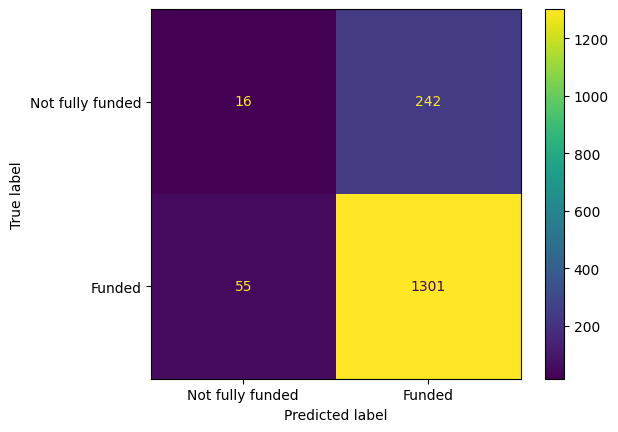

In [34]:
display_cm_donors = ConfusionMatrixDisplay(confusion_matrix=cm_donors, display_labels=["Not fully funded","Funded"])
display_cm_donors.plot();

In [35]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.225     0.062     0.097       258
           1      0.843     0.959     0.898      1356

    accuracy                          0.816      1614
   macro avg      0.534     0.511     0.497      1614
weighted avg      0.744     0.816     0.770      1614



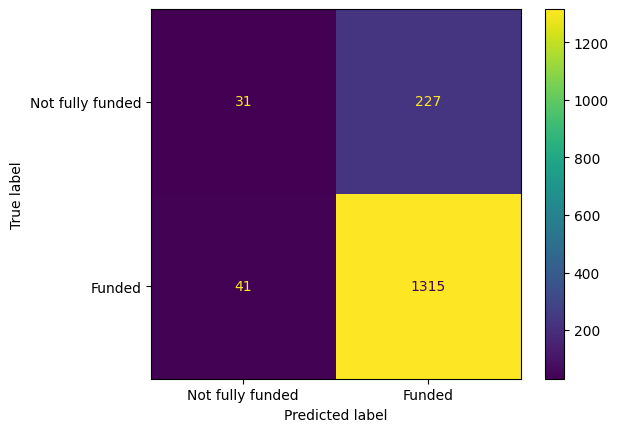

In [36]:
# Naive Bayes
nb_hf = GaussianNB()
nb_pred = nb_hf.fit(X_train, y_train).predict(X_test)
cm_hf = confusion_matrix(y_test,nb_pred)
display_cm_hf= ConfusionMatrixDisplay(confusion_matrix=cm_hf,
                                       display_labels=['Not fully funded','Funded'])
display_cm_hf.plot();

In [37]:
print(classification_report(y_test, nb_pred, digits=3, target_names=['Not fully funded','Funded']))

                  precision    recall  f1-score   support

Not fully funded      0.431     0.120     0.188       258
          Funded      0.853     0.970     0.908      1356

        accuracy                          0.834      1614
       macro avg      0.642     0.545     0.548      1614
    weighted avg      0.785     0.834     0.792      1614



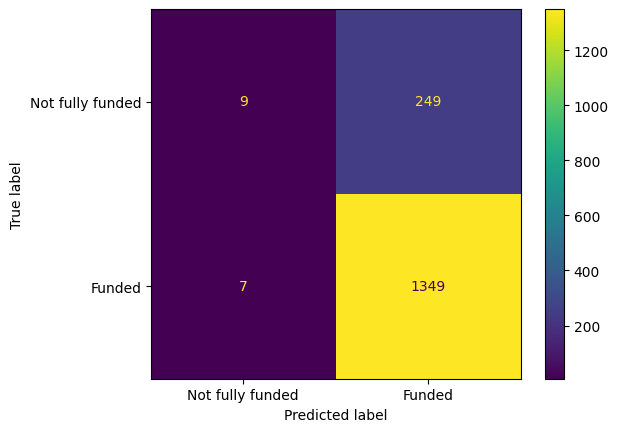

In [38]:
# LogisticRegression
lr_hf = LogisticRegression(max_iter=1000)
lr_hf.fit(X_train, y_train)
lr_pred = lr_hf.predict(X_test)

cm_lr = confusion_matrix(y_test,lr_pred)
display_cm_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,display_labels=['Not fully funded','Funded'])
display_cm_lr.plot();

In [39]:
print(classification_report(y_test, lr_pred, digits=3, target_names=['Not fully funded','Funded ']))

                  precision    recall  f1-score   support

Not fully funded      0.562     0.035     0.066       258
         Funded       0.844     0.995     0.913      1356

        accuracy                          0.841      1614
       macro avg      0.703     0.515     0.490      1614
    weighted avg      0.799     0.841     0.778      1614



In [40]:
# DecisionTree
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [41]:
dtr = DecisionTreeRegressor(random_state=1)
parameters = {'max_depth': [10,20,30,40,50,60],
              'splitter': ('best','random')}

dtr_tuned = GridSearchCV(dtr, parameters, cv=10)
dtr_tuned.fit(X_train, y_train)
print("------ Best Parameters  ----------")
print(dtr_tuned.best_params_)
print("------ Best Model Train Accuracy ----------")
print(dtr_tuned.score(X_train, y_train))
print("------ Best Model Test Accuracy ----------")
print(dtr_tuned.score(X_test, y_test))

------ Best Parameters  ----------
{'max_depth': 10, 'splitter': 'best'}
------ Best Model Train Accuracy ----------
0.8947425002595427
------ Best Model Test Accuracy ----------
0.5511554839129956


# Question 3

Write a one-paragraph discussion of your results for a non-technical decision-maker with any recommendations for deployment or next steps. What are the policy recommendations you would make to them?

Based on my findings, projects that were funded by a teacher tend to do very well so I would suggest advertising to teachers as they tend to support each other. Of course schools that are located in poorer zipcodes recieve a lot of attention as they are more likely to need funds, as evident by my EDA earlier. In terms of most common categories coming up, supplies tend to be a huge reason for seeking donations, and they tend to be low dollar items in higher quantities (for a classroom). I would suggest teachers asking for donations, keep the item count low as well as asking for lower funds as it is more likely to be funded.

In the future from a technical perspective, I would approach it as an NLP problem whereby using sentiment analysis on essays, I can hone into specific vocabulary keywords. From this the aim would be to find certain words that are associated with high amounts of funding, as advice for teachers to implement in their essays.

# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Include a link to your copy of the notebook when you fill out [this survey](https://datascience.wufoo.com/forms/fall-2023-ml-for-public-policy-lab-survey/) along with your other details.

Thank you and we're looking forward to a great semester in 94889!